# RateML
## Defining new models in TVB using RateML

In this demo we show how to use RateML for automatic code generation of models defined in LEMS based XML to Python format and run a simulation in TVB.

First let us gather the latest version (currently a beta), if already cloned one should do a '!git pull'

In [ ]:
!git clone https://github.com/DeLaVlag/tvb-root.git

In [ ]:
# install tvb-library
%cd tvb-root/scientific_library/
!python setup.py install
# install tvb-bin
%cd ../tvb_bin
!python setup.py install
# install tvb-data
! pip install tvb-data
%cd ../../

## Building a model
Building rate based models in RateML, start by creating an XML model file. To understand which constructs can be used to build the model, one should take a closer look at the README file. The cell below will prints the latest README file from the repository. Every construct which can be used, is explained. The Python model generation has no coupling nor noise specification through RateML, therefore one can skip reading the coupling, noise and 'running an example' sections.

In [9]:
from IPython.display import Markdown, display, Code
mdfile = open("tvb-root/scientific_library/tvb/rateML/README.md","r")
model = mdfile.read()
display(Markdown(model))
mdfile.close()

## Rate based model generation for Python TVB or CUDA models
This readme describes the usage of the code generation for models defined in LEMS based XML to Cuda or Python.
The pyLEMS framework is used and will be installed with TVB. 
XML2model.py holds the class which start the templating.
To use RateML, create an object of the RateML class in which the arguments: the model filename, language, XML file location and model output location, are entered.
```python
RateML('model_filename', language=('python' | 'cuda'), 'path/to/your/XMLmodels', 'path/to/your/generatedModels')
```
The model filename is the name of XML file which will also be the name of the model class for Python models and the kernel name for CUDA models. 
The language (python | cuda) determines if either a python or cuda model will be generated. 
It expects a model_filename.xml to be present in 'path/to/your/XMLmodels' for either Python or CUDA model generation.
The generated file will be placed in ''path/to/your/generatedModels'.
The produced filename is a lower cased model_filename.c or -.py which contains a kernel called model_filename or a class named Model_filenameT.

    .. moduleauthor:: Michiel. A. van der Vlag <m.van.der.vlag@fz-juelich.de>
    .. moduleauthor:: Marmaduke Woodman <marmaduke.woodman@univ-amu.fr>
    .. moduleauthor:: Sandra Diaz <s.diaz@fz-juelich.de>

## XML template
The XML template below can be found in /XMLmodels and can be used to start the construction of a model. This section describes each of the constructs need to define the model.
Both CUDA and Python can be generated from the same XML model file, however the CUDA variant would need componenttypes for coupling and noise. 
The order of constructs in this figure denotes the sequences in which they need to appear in the XML file. The Pylems expression parser, which checks for mathematical correctness, is active on all the fields which hold expressions. The power symbol in the expression fields needs to be entered within curly brackets: {x^2}, because it needs to be translated to the specific power operator for each language.

```xml
<?xml version="1.0" encoding="UTF-8"?>
<Lems description="Rate based generic template">

```

### Derivatives
To define the time derivatives of the model, a component type with the name: “derivatives”, should be created. This component type can hold other constructs which define the initialization and dynamics definition of the model. 
```xml
    <ComponentType name="derivatives">
```
\
The **Parameter** construct defines variables to be used in a parameter sweep. The name keyword specifies the name and the dimension keyword specifies the type of the parameter. Parameter is only supported by CUDA. rateML/run/__main__.py holds an example of coupling and speed exploration. In this example the coupling parameters have the range: logspace(1.6, 3.0, coupling_runtime_dimension) and speed parameters have the range logspace(1.6, 3.0, speed_runtime_dimension)
```xml
        <Parameter name="[p_name0]" dimension='[type=float]'/>
        <Parameter name="[p_name1]" dimension='[type=float]'/>
```
\
The **DerivedParameter** construct specifies parameters which are derived during run-time of the model in dependence of the parameters used in sweeps. This construct is only supported by the CUDA models and will generate a float with the const keyword, which is initialized with the expression. Special derived parameters are “rec_speed_dt” and “nsig”. If “rec_speed_dt” is not defined the coupling will not have a temporal aspect, meaning that the delay between nodes will be set to 0. If the added noise needs to be amplified the keyword “nsig” should be used. See coupling and noise sections for more information.
```xml
        <DerivedParameter name="[name]" expression="[expression]"/>
```
\
The **Constant** construct is used to create constants of the type float. The value field represents the initial value and a description can be entered optionally in the description field. (TODO. Description bug in LEMS: The description attibute is mapped to the symbol attribute in LEMS.py. For now no description field does not translate to description field in Python generations). For the Python models a domain must be specified, this can be done in the dimension field. Either the domain in the format as listed is entered, or None is entered to exclude it. This domain is used to generate GUI slider bars and value validation in the TVB Framework. For the CUDA models, the dimension field can be omitted.
```xml
        <Constant name="[name]" domain="lo=[value], hi=[value], step=[value]" default="[value]" description="[optional]"/>
```
\
The **Exposures** construct specifies variables that the user wants to monitor and that are returned by the computing kernel: name is the name of the variable to be monitored, the keyword dimension defines any mathematical operation performed on a variable of interest. 
```xml
        <Exposure name="[name]" dimension="[Expression]"/>
```
\
The **StateVariable** construct is used to define the state variables of the model. The state variables in a Python TVB model are initialized with a numpy.array with the values entered in the dimension field. This field can be omitted in the CUDA models, in which state variables are single variables initialized to 0. The exposure field sets the state variables' upper and lower boundaries, for both languages. These boundaries ensure that the values of state variables stay within the set boundaries and resets the state if the boundaries are exceeded.
```xml
        <Dynamics>
            <StateVariable name="[name]" dimension="[range]" exposure="[lower_bound], [upper_bound]"/>
```
\
The **DerivedVariable** construct can be used to define temporary variables which are the building blocks of the time derivatives. Any formula can be used, and the syntax is: name=value.
```xml
            <DerivedVariable name="[name]" value="[expression]" />
```
\
The **ConditionalDerivedVariable** construct can be used to create if-else constructs. Within the construct a number of Cases can be defined to indicate what action is valid when the condition is true of false. The condition field holds the condition for the action. The escape sequences '\&lt(=);' and '\&gt;(=)' for less- or greater then (or equal to) are used to specify the condition. The value field holds the expression of which the value will be assigned to the variable indicated with the name field. At least one case should be defined. Two cases will produce an if-else structure. There is no need to enter the ‘else’ keyword as is shown in the example, this will be produced automatically. More than two cases will result in the usage of ‘else-if’ statements.
```xml
            <!--if [condition]: [name] = [expression1]
                else if [condition]: [name] = [expression2] 
                else: [expression3] -->
            <ConditionalDerivedVariable name="[name]">
                <Case condition="[variable] [conditional operator] [value]" value="[expression1]"/>
                <Case condition="[variable] [conditional operator] [value]" value="[expression2]"/>
                <Case condition="" value="[expression3]"/>
            </ConditionalDerivedVariable>
```
\
The **TimeDerivative** construct defines the model dynamics in terms of  derivative functions. The variable field specifies the variable on the left-hand side of the differential equation, while the value field specifies the right-hand side expression. 
```xml
            <TimeDerivative variable="[name]" value="[expression]"/>
        </Dynamics>
    </ComponentType>
```

### Coupling
To define **coupling functions**, which is only applicable for CUDA models, the user can create a coupling component type.
To identify this coupling component type, the name field should include the phrase coupling. It will construct a double for loop in which for every node, every other node's state is fetched according to connection delay, multiplied by connection weight.
The Python models have coupling functionality defined in a separate class which contains pre-defined functions for pre- and post synaptic behavior. With RateML it is not possible to define the coupling function for the Python models. For the python models, a number of hardcoded c_pop variables are defined, which can be used to implement the coupling value per population. Each of these variables define the coupling for each neuron population defined.
```xml
    <ComponentType name="coupling_[name]">
```
\
The coupling **Parameter** construct specifies the variable that stores intermediate results from computing coupling inputs and its dimension field indicates which state variable the coupling computation should consider and which is fetched from memory. For instance, in case of the Epileptor model, six state variables are present and either one of them could (theoretically) be considered in computing the coupling. This function has been added to give the user more freedom in defining the coupling function. The dimension param indicates the nth defined statevariable of which values are fetched from memory.
The parameter name should appear in the user defined 'pre' or 'post' coupling function, if user want temporal model aspects.
```xml
        <Parameter name="[name]" dimension='[0-n]'/>
```
\
The coupling **DerivedParameter** construct defines the name of the variable to store the final coupling result and the value field contains a function that transforms the sums of all inputs to a specific node. This variable, 'dp_name', can be used to incorporate the coupling value in the dynamics of the model and is eventually used to 'export' the coupling value out of the for loops. This value should then be used in time derivative definition 
Syntax: [name] *= [expression].
```xml
        <DerivedParameter name="[dp_name]" value="[expression]"/>
```
\
The **DerivedVariable** construct can be used to enter a 'pre'- and 'post'-synaptic coupling function. The final result is that the pre- is multiplied with the post synaptic coupling function and again multiplied with the weights of the node. This result is assigned to 'dp_name', which is shown on line 16 of the listing below. If the derivatives component type does not have a derived parameter named 'rec_speed_dt' the coupling function will not have the delay aspect and thus does not have a temporal component. The listing below also shows the fetching of the delays and the usage of 'rec_speed_dt'. If 'rec_speed_dt' is not defined 'dij' will be set to 0. Other variables or constants defined inside or outside of this component type, can also be used to populate this function.
```xml
        <Dynamics>
            <!-- Construct to define the pre and post coupling function
                Name should always be 'pre' and 'post'
                [dp_name] += node_weight * [pre.expression] * [post.expression] -->
            <DerivedVariable name="[pre]" value="[expression]"/>
            <DerivedVariable name="[post]" value="[expression]"/>
        </Dynamics>
    </ComponentType>

    <!-- It is possible to decribe a 2nd coupling funtion, with the same as the syntax as previous. -->
    <ComponentType name="coupling_function_pop2">
            
        <!-- etc... -->
    </ComponentType>
```

### Noise
To specify **noise addition** to the model dynamics, a component type with the name 'noise' can be defined, which is only applicable for CUDA models. The CUDA models make use of the Curand library to add a random value to the calculated derivatives. As is mentioned in the derivatives section, if the derivatives component type has a derived parameter with the name 'nsig' a noise amplification of value will be used to amplify the noise. 
```xml
    <!--Type noise for noise. Only for CUDA models. 
        Will add curand noise to state variable and amplify with constant 'nsig' if defined.
        [state_var_name] += nsig * curand_normal(&crndst) + [time_der_var] -->
    <ComponentType name="noise"/>


</Lems>
```

```c
// Loop over nodes
for (int i_node = 0; i_node < n_node; i_node++){
    c_pop1 = 0.0f;
    V = state((t) % nh, i_node + 0 * n_node);
  unsigned int i_n = i_node * n_node
     // Loop over nodes
     for (unsigned int j_node = 0; j_node < n_node; j_node++){
       // Get the weight of the coupling between node i and node j
       float wij = weights[i_n + j_node];
       if (wij == 0.0) continue;
       // Get the delay between node i and node j
       unsigned int dij = lengths[i_n + j_node] * rec_speed_dt;
       // Get the state of node j which is delayed by dij
       float V_j = state(((t - dij + nh) % nh), j_node + 0 * n_node);
       // Sum using coupling function (constant * weight * pre * post)
       c_pop1 += wij * c_c_a * 2 * sin(V_j - V);
    }
}
// Export c_pop1 outside loop and process
c_pop1 *= global_coupling;
// Do derivative calculation
...
```
*Listing 1. Generated CUDA code for the coupling functionality*

### Numba and Python coupling
In RateML the dynamics of the Python rate models are integrated using Numba vectorization (Lam et al., 2015). They are mapped to a generalized universal function (gufuncs) using Numba's guvectorize decorator to compile a pure Python function directly into machine code that operates over NumPy arrays, as fast as a C implementation (Numba, “Creating NumPy universal functions.”, https://numba.pydata.org/numba-doc/latest/user/vectorize.html). An example of a Numba generated guvectorize function is displayed in Listing 2. In this example the gufunc *_numba_dfun_Epileptor* accepts two n and m sized float64 arrays and 19 scalars as input and returns a n sized float64 array. The benefit of writing Numpy gufuncs with Numba's decorators, is that it automatically uses features such as reduction, accumulation and broadcasting to efficiently implement the algorithm in question.
The Python models have coupling functionality defined in a separate class which contains pre-defined functions for pre- and post synaptic behavior. With RateML it is not possible to define the coupling function for the Python models. For these models, as is shown in listing 2, a number of hardcoded c_pop*n* variables are defined, which can be used to implement the coupling value per population. Each of these variables define the coupling for each neuron population defined.
```python
@guvectorize([(float64[:], float64[:], (float64 * 19), float64[:])], 
    '(n),(m)' + ',()'*19 + '->(n)', nopython=True)
def _numba_dfun_EpileptorT(vw, coupling, a, b, c, d, r, s, x0, Iext, slope, 
    Iext2, tau, aa, bb, Kvf, Kf, Ks, tt, modification, local_coupling, dx):

    c_pop1 = coupling[0]
    c_pop2 = coupling[1]
    c_pop3 = coupling[2]
    c_pop4 = coupling[3]
    ... # calculate derivatives
    
    return dx
```
*Listing 2. Generated CUDA code for the coupling functionality*

## Files in ~/rateML/
* XML2model.py   		    : python script for initiating model code generation of either CUDA or Python models
* tmpl8_cuda.py 		    : Mako template converting XML to CUDA
* tmpl8_python.py 		    : Mako template converting XML to Python
* /XMLmodels                : folder containing LEMS based XML model example files as well as a model template
* /generatedModels          : resulting model folder
* /run/                     : folder with example script to run generated model
* /run/__main__.py          : cuda setup file
* /run/cuda_run.py          : cuda run file using Pycuda


## Requirements
* Mako templating
* Pycuda
* pyLEMS


## Running an example from ~/run folder
In the folder 'tvb/rateML/run/' an example can be found on how to run the model generator and the CUDA model on a GPU. From this folder, execute \_\_main\_\_.py on a CUDA enabled machine: 
```bash 
python ./__main__.py --model [model_filename] -c [coupling dimension] -s [speed dimension] 
```

The block dimensions default to 32x32 which has shown to have the best occupancy, the grid is adjusted accordingly. In the output.out a small report on the success of the simulation is printed. 

## Generate and Run an example model
After reading the README, one should be able to build an XML model file. Lets use the relatively small Kuramoto model as an example. 
Your model should look like similar to the Kuramoto python file and define some constants, an exposure and dynamics behavior. The dynamics for the Kuramoto consist of a state variable, a derived variable and a time derivative. Except for the derived variable, there are the construct that a RateML XML model file should contain.

In [10]:
# Open the Kuramoto model
model_location = "tvb-root/scientific_library/tvb/rateML/XMLmodels/kuramoto_python.xml"
xmlfile = open(model_location,"r")
model =xmlfile.read()
display(Markdown(model))
xmlfile.close()

<Lems description="Kuramoto Base type of any cell/population which has a (dimensionless) rate _R.">

    <ComponentType name="derivatives">

        <Constant name="omega" 
                  value="1.0" 
                  dimension="lo=0.01, hi=200.0, step=0.1"  
                  description="sets the base line frequency for the Kuramoto oscillator in [rad/ms]"/>

        <Exposure name="theta" dimension="theta" />

        <Dynamics>
            <!-- Use PI to select the PI wrapper (ie Kuramoto) -->
            <StateVariable name="theta" dimension="0.0, numpy.pi * 2.0"/>
            
            <DerivedVariable name="coupl_strength" value="c_pop1 * sin(theta)" />

            <TimeDerivative variable="dtheta" value="omega + coupl_strength"/>
        </Dynamics>
    </ComponentType>
</Lems>

## Automatically generating the model code and integrating it into TVB

We will call the templating function in order to automatically generate the model code. This will be directly moved to the right path in the tvb library so it will be recognized by the simulator when we call it later. 
In XML2model.py the class 
```python
RateML('model_filename', language=('python' | 'cuda'), 'path/to/your/XMLmodels', 'path/to/your/generatedModels')
``` 
will start the code generation.

In [11]:
from tvb.rateML.XML2model import RateML
# Start generation

# some preexisting examples:
# model_filename = 'montbrio'
# model_filename = 'oscillator'
# model_filename = 'kuramoto'
# model_filename = 'rwongwang'
# model_filename = 'epileptor'
model_filename = "kuramoto_python"
language = "python"
XMLin = "tvb-root/scientific_library/tvb/rateML/XMLmodels"
GenModOut = "tvb-root/scientific_library/tvb/rateML/generatedModels"
RateML(model_filename, language, XMLin, GenModOut)

2020-11-18 16:26:13,996 - INFO - tvb.rateML.XML2model - True validation of tvb-root/scientific_library/tvb/rateML/XMLmodels/kuramoto_python.xml against https://raw.githubusercontent.com/DeLaVlag/tvb-root/xsdvalidation/scientific_library/tvb/rateML/rML_v0.xsd
2020-11-18 16:26:14,023 - INFO - tvb.rateML.XML2model - model file generated kuramoto_python


It will also do XSD validation against rateML/rML_v0.xsd and report validity. If all is well, it should report that the file was generated. Next to the output directory it will place a copy of the model in the TVB simulator folder and make it recognizable for TVB.
Let take a look at the generated model file:

In [12]:
# Open the generated python Kuramoto model
model_location = "tvb-root/scientific_library/tvb/rateML/generatedModels/kuramoto_python.py"
genModFile = open(model_location,"r")
model = genModFile.read()
display(Code(model, language='python'))
# display(Markdown(model))
xmlfile.close()

from tvb.simulator.models.base import Model, ModelNumbaDfun
import numexpr
import numpy
from numpy import *
from numba import guvectorize, float64
from tvb.basic.neotraits.api import NArray, Final, List, Range

class Kuramoto_pythonT(ModelNumbaDfun):
        
    omega = NArray(
        label=":math:`omega`",
        default=numpy.array([1.0]),
        domain=Range(lo=0.01, hi=200.0, step=0.1),
        doc=""""""
    )    

    state_variable_range = Final(
        label="State Variable ranges [lo, hi]",
        default={"theta": numpy.array([0.0, numpy.pi * 2.0])},
        doc="""state variables"""
    )

    variables_of_interest = List(
        of=str,
        label="Variables or quantities available to Monitors",
        choices=('theta', ),
        default=('theta', ),
        doc="Variables to monitor"
    )

    state_variables = ['theta']

    _nvar = 1
    cvar = numpy.array([0], dtype=numpy.int32)

    def dfun(self, vw, c, local_coupling=0.0):
        vw_ = vw.reshape(vw.shape[:-1]).T
        c_ = c.reshape(c.shape[:-1]).T
        deriv = _numba_dfun_Kuramoto_pythonT(vw_, c_, self.omega, local_coupling)

        return deriv.T[..., numpy.newaxis]

@guvectorize([(float64[:], float64[:], float64, float64, float64[:])], '(n),(m)' + ',()'*2 + '->(n)', nopython=True)
def _numba_dfun_Kuramoto_pythonT(vw, coupling, omega, local_coupling, dx):
    "Gufunc for Kuramoto_pythonT model equations."

    # long-range coupling
    c_pop1 = coupling[0]
    c_pop2 = coupling[1]
    c_pop3 = coupling[2]
    c_pop4 = coupling[3]

    theta = vw[0]

    # derived variables
    coupl_strength = c_pop1 * sin(theta)

    dx[0] = omega + coupl_strength

## Simulating the result
If the model displays all its features to your whishes. It is time to take her for a spin in TVB.
If it simulates, the time series of your generated model will be plotted on screen.

2020-11-18 16:26:29,995 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


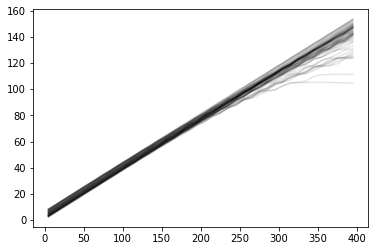

In [13]:
from matplotlib.pyplot import *
from tvb.rateML.run.regular_run import regularRun

simtime = 400
g = 2
s = 2
dt = 0.1
period = 10
your_gen_model = 'Kuramoto_pythonT'
(time, data) = regularRun(simtime, g, s, dt, period).simulate_python(your_gen_model)

figure()
plot(time, data[:, 0, :, 0], 'k', alpha=0.1)
show()